# Analysis of Customer Behavior Patterns Using LSTM/Transformers

This notebook demonstrates how customer behavior patterns can eb analyzed in the space of attention weights extracted for sequential models such as LSTM with Attention or Transformers.

### Use Case
We have a large number of customer event histories (journeys). Each history represents a sequence of real-valued measurements and labeled with an outcome class (conversion, churn, etc.) Out goal is to provide insight into behavioral patterns within each class, pattern difference between the classes, and contributions of individual events into the outcome (e.g. the most recent events are twice more important than old ones).

### Prototype: Approach and Data
We generate a dataset that simulates customer event histories and then use LSTM with attention to predict customer behavior, and analyze the contributions of individual events into the predicted outcome. Each event is represented by a single real value - in real-world applications, this should be extended to a vector. 

### Usage and Productization
This prototype can be used to validate whether the weight-based approach provides useful insight or not. If the initial results look promising, a deeper pattern analysis and interpretation can be performed. 

In [1]:
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
plt.rcParams.update({'font.size': 12, 'pdf.fonttype': 'truetype'})

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, auc

from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import LSTM, Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from tensorflow.keras import backend as K

# Step 1: Generate a Basic Data Sample

The first step is to generate customer event histories:
* Each customer history includes 20 "events" each of which is a real one-element vector, but an event generally can have an arbitrary number of dimensions. We use one-dimensional event to simplify illustrations.
* Each customer is attributed with a binary outcome label. The semantic meanining of such a label can be churn, conversion, or some other event of interest.
* Histories with "positive" outcomes have a special feaure: two random event positions towards the end of the history are multiplied by some coeffecients. 
* Gaussian white noise is added on top of the event samples.

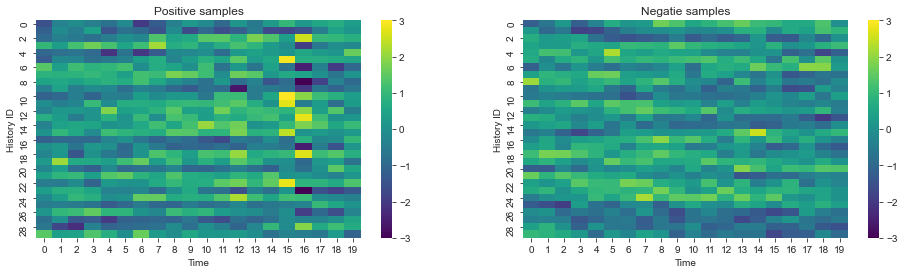

In [2]:
events_per_history = 20
n_samples = 10000 
np.random.seed(1234)
event_histories = np.zeros((n_samples, events_per_history))
outcomes = np.random.binomial(1, 0.5, n_samples)

for i in range(n_samples):
    phase = np.random.normal(0, 10)
    for t in range(events_per_history):
        event_histories[i, t] = np.sin(phase + np.pi / 20 * t)
    if outcomes[i] > 0:
        event_histories[i, -8 + np.random.randint(-1, 1)] *= 2
        event_histories[i, -4 + np.random.randint(-1, 1)] *= 3

# additive noise        
event_histories += np.random.normal(0, 0.5, event_histories.shape)
            
positive_idx, negative_idx = [np.argwhere(outcomes == x).ravel() for x in [1,0]]
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
for i, idx in enumerate([positive_idx, negative_idx]):
    sns.heatmap(event_histories[idx][:30], cmap='viridis', ax=ax[i], vmin=-3, vmax=3)
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('History ID')
ax[0].set_title('Positive samples');
ax[1].set_title('Negative samples');

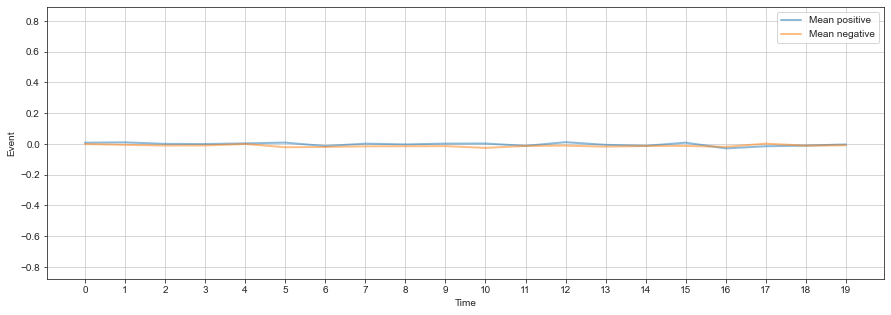

In [3]:
#
# Note that although the "special mark" is clearly visible in the history heatmaps, 
# the mean of histories over all samples is basically zero for both positive and negative cohorts
# as shown in the plot below (multiplicative coefficients do not introduce any bias)
#
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(np.mean(event_histories[positive_idx], axis=0), label='Mean positive', linewidth=2, alpha=0.5)
ax.plot(np.mean(event_histories[negative_idx], axis=0), label='Mean negative', linewidth=2, alpha=0.5)
ax.grid(True)
ax.set_xlabel('Time')
ax.set_ylabel('Event')
ax.set_xticks(range(events_per_history))
ax.set_ylim([np.min(event_histories)/5, np.max(event_histories)/5])
ax.legend();

# Step 2: Fit LSTM with Attention Model

We next fit an LSTM with attention model, and plot its ROC curve and confusion matrix to make sure it works as expected.

In [4]:
#
# Feature engineering for Keras: 3D tensor for LSTM (n_samples x events_per_history x n_features_per_event)
#
n_features = 1
x = event_histories.reshape((n_samples, events_per_history, n_features))

#
# Train-test split
#
x_train, x_test, y_train, y_test = train_test_split(x, outcomes, test_size = 0.25, random_state = 1)

In [39]:
#
# Model parameters
#
hidden_units = 8

#
# Model specification
#
input_logs = Input(shape=(events_per_history, n_features))

# LSTM
activations = LSTM(hidden_units, return_sequences=True)(input_logs)

attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_weigths')(attention)
attention = RepeatVector(hidden_units * 1)(attention)
attention = Permute([2, 1])(attention)

weighted_activations = Multiply()([activations, attention])
weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)

lstm = Model(inputs=input_logs, outputs=weighted_activations)

# Model head
dense_top = Dense(32, activation='relu')(lstm.output)
outcome_prob = Dense(1, activation='sigmoid')(dense_top)
model = Model(inputs=[lstm.input], outputs=outcome_prob)

#
# Model training
#
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit([x_train], y_train, batch_size=4, epochs=16, verbose=1, validation_data=([x_train], y_train)) 
score = model.evaluate([x_test], y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/16
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6737 - accuracy: 0.5800 - val_loss: 0.6279 - val_accuracy: 0.6648
Epoch 2/16
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5920 - accuracy: 0.6876 - val_loss: 0.5674 - val_accuracy: 0.7076
Epoch 3/16
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5468 - accuracy: 0.7160 - val_loss: 0.5279 - val_accuracy: 0.7363
Epoch 4/16
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4866 - accuracy: 0.7569 - val_loss: 0.4590 - val_accuracy: 0.7781
Epoch 5/16
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4498 - accuracy: 0.7735 - val_loss: 0.4397 - val_accuracy: 0.7804
Epoch 6/16
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4414 - accuracy: 0.7813 - val_loss: 0.4548 - val_accuracy: 0.7668
Epoch 7/16
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4382 - accuracy: 0.7799 - val_loss: 0.4177 - val_accuracy:

In [40]:
def plot_roc(y_test, y_hat_prob):
    plt.figure(figsize=(8, 8))
    false_positive_rate, recall, thresholds = roc_curve(y_test, y_hat_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'r', label = 'AUC = %0.3f' % roc_auc)
    plt.fill_between(false_positive_rate, recall, color='r', alpha=0.025)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1 - Specificity)')
    plt.show()
    
    
def plot_confusion_matrix(y, y_hat_prob, labels):
    y_hat = np.where(y_hat_prob > 0.5, 1, 0) # probability to 0-1 binary
    cm = confusion_matrix(y, y_hat)
    accuracy = accuracy_score(y, y_hat)
    plt.figure(figsize=(4, 4));
    sns.heatmap(cm, xticklabels = labels, yticklabels = labels, 
                annot = True, cbar=False, fmt='d', annot_kws={'size': 16}, 
                cmap="Wistia", vmin = 0.2);
    plt.title(f'Confusion Matrix\n({len(y)} samples, accuracy {accuracy:.3f})')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

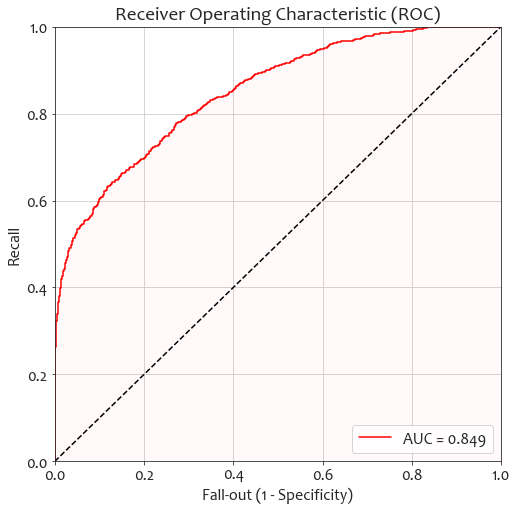

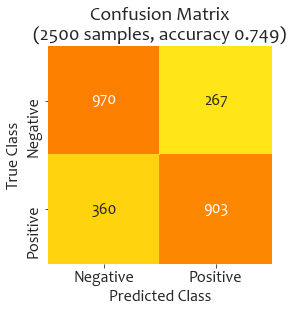

In [41]:
# plot ROC and confusion matrix
predictions_lstm_a_prob = model.predict([x_test])
plot_roc(y_test, predictions_lstm_a_prob)
plot_confusion_matrix(y_test, predictions_lstm_a_prob, ['Negative', 'Positive'])

# Step 3: Analyze the Attention Weigth Profiles

We next analyze the attention weights. We can see that attention vectors clearly highlight the "special mark", and the mean of attention vectors is sharply different between the positive and negative cohorts.

Attention weights matrix: 2500 users x 20 weights


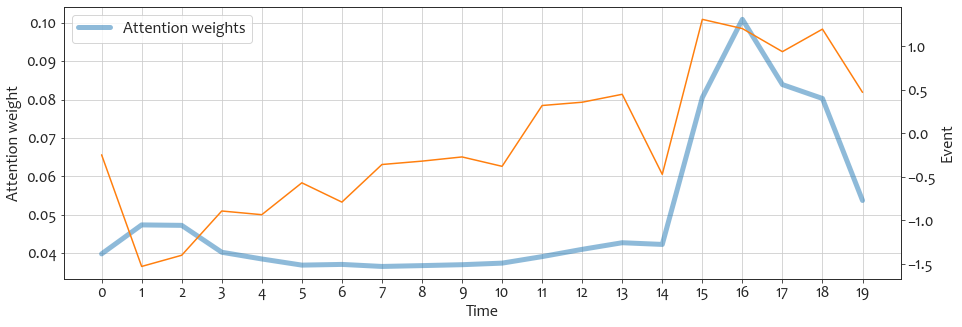

In [42]:
#
# Attention weights analysis
#

attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weigths').output)
a = attention_model.predict([x_test])
print(f'Attention weights matrix: {a.shape[0]} users x {a.shape[1]} weights')

uid = 13
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(a[uid, :], label='Attention weights', linewidth=5, alpha=0.5)
ax.set_ylabel('Attention weight')
ax2 = ax.twinx() 
ax2.plot(x_test[uid], label='x', color='#ff7f0e')
ax2.set_ylabel('Event')
ax.set_xlabel('Time')
ax.grid(True)
ax.set_xticks(range(events_per_history))
ax.legend();
plt.savefig('example-trajectory.pdf')

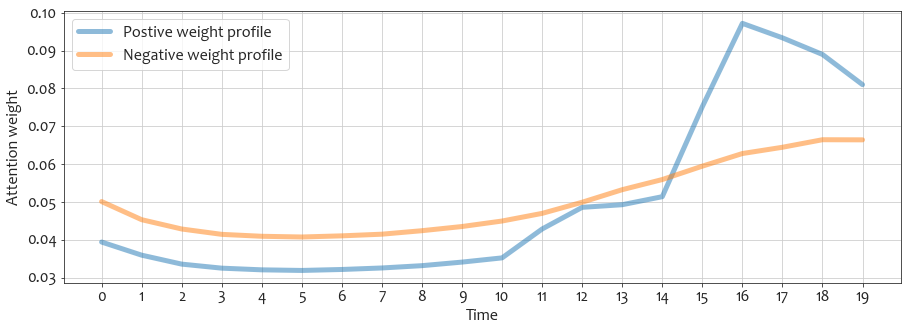

In [43]:
yp_idx, yn_idx = [np.argwhere(y_test == x).ravel() for x in [1,0]]

fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(np.mean(a[yp_idx, :], axis=0), label='Postive weight profile', linewidth=5, alpha=0.5)
ax.plot(np.mean(a[yn_idx, :], axis=0), label='Negative weight profile', linewidth=5, alpha=0.5)
ax.grid(True)
ax.set_xlabel('Time')
ax.set_ylabel('Attention weight')
ax.set_xticks(range(events_per_history))
ax.legend();

# Step 4: Cluster the Histories in the Space of Attention Weights

Finally, we project the attention weight vectors on 2D plane using tSNE. We can see that positive and negative chorots form clusters in this space. This way one indeed can identify behavioral patterns in the space of attention weights.

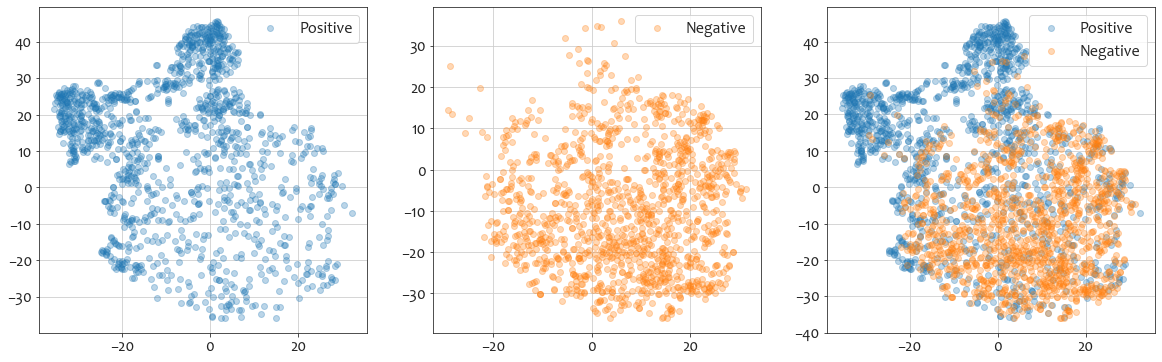

In [44]:
from sklearn.manifold import TSNE
a_embedded = TSNE(n_components=2, perplexity=60).fit_transform(a)

#font = {'family' : 'Candara', 'size'   : 16}
#plt.rc('font', **font)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i in [(0,1), (2,2)]:
    ax[i[0]].scatter(a_embedded[yp_idx, 0], a_embedded[yp_idx, 1], alpha=0.3, c='#1f77b4', label='Positive')
    ax[i[1]].scatter(a_embedded[yn_idx, 0], a_embedded[yn_idx, 1], alpha=0.3, c='#ff7f0e', label='Negative')
    
for axi in ax:
    axi.legend()
    axi.grid(True)